In [1]:
from mobster_mv import mobster_MV
from BoundedPareto import BoundedPareto
import numpy as np
import pyro
import pyro.distributions as dist

import torch
from torch.distributions import constraints

import matplotlib.pyplot as plt

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def pareto_binomial_component(alpha, L, H, p, n, N, seed):
    """
    Create pareto-binomial component: 
    x-axis is a Pareto-Binomial
    y-axis is a Beta-Binomial
    """
    pyro.set_rng_seed(seed)
    d1 = torch.ones([N, 2]) # component 1
    
    # x-axis component 1
    for i in range(N):
        p_p = BoundedPareto(scale=L, alpha = alpha, upper_limit = H).sample().float()
        d1[i, 0] = dist.Binomial(total_count=n, probs=p_p).sample().squeeze(-1)

    d1[:, 1] = dist.Binomial(total_count=n, probs=p).sample([N]).squeeze(-1)
    DP = torch.ones([N, 2]) * n

    return d1, DP
    

In [3]:
def beta_binomial_component(p_x, p_y, n, N,seed):
    """
    Create beta-binomial component: 
    x-axis is a Beta-Binomial
    y-axis is a Beta-Binomial
    """
    pyro.set_rng_seed(seed)
    d2 = torch.ones([N, 2]) # component 2
    # x-axis component 2
    d2[:, 0] = dist.Binomial(total_count=n, probs=p_x).sample([N]).squeeze(-1)
    
    # y-axis component 2
    d2[:, 1] = dist.Binomial(total_count=n, probs=p_y).sample([N]).squeeze(-1)

    DP = torch.ones([N, 2]) * n

    return d2, DP

In [4]:
N1 = 2000
N2 = 1000
NV1, DP1 = pareto_binomial_component(alpha=2, L=0.05, H=0.5, p=0.5, n=100, N=N1, seed = 123)
NV2, DP2 = beta_binomial_component(p_x=0.5, p_y=0.5, n=150, N=N2, seed=123)
NV = torch.concat((NV1,NV2))
print(NV.shape)
# print(NV)
DP = torch.concat((DP1,DP2))
print(DP.shape)
# print(DP) 

torch.Size([3000, 2])
torch.Size([3000, 2])


In [5]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
    
labels = np.concatenate((labels_1, labels_2))

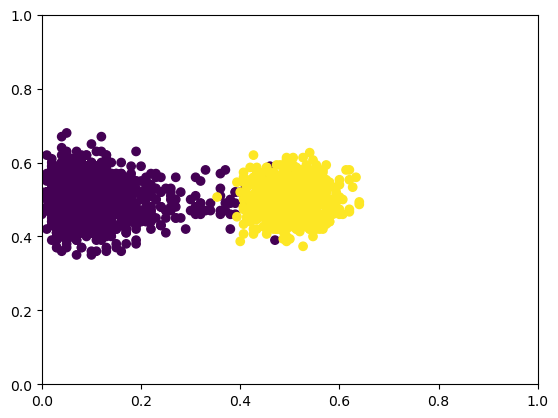

In [6]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

In [7]:
mb = mobster_MV(NV, DP, K = 2, seed = 12)

tensor([[0.0868, 0.4993],
        [0.4951, 0.5026]], grad_fn=<ClampBackward1>)
Iteration 0: Loss = 87044640.0
tensor([[0.0868, 0.4995],
        [0.4954, 0.5023]], grad_fn=<ClampBackward1>)
tensor([[0.0867, 0.4994],
        [0.4955, 0.5024]], grad_fn=<ClampBackward1>)
tensor([[0.0866, 0.4992],
        [0.4956, 0.5025]], grad_fn=<ClampBackward1>)
tensor([[0.0865, 0.4991],
        [0.4955, 0.5026]], grad_fn=<ClampBackward1>)
tensor([[0.0864, 0.4992],
        [0.4954, 0.5026]], grad_fn=<ClampBackward1>)
tensor([[0.0864, 0.4992],
        [0.4953, 0.5025]], grad_fn=<ClampBackward1>)
tensor([[0.0863, 0.4993],
        [0.4952, 0.5024]], grad_fn=<ClampBackward1>)
tensor([[0.0862, 0.4994],
        [0.4952, 0.5024]], grad_fn=<ClampBackward1>)
tensor([[0.0861, 0.4994],
        [0.4952, 0.5024]], grad_fn=<ClampBackward1>)
tensor([[0.0860, 0.4994],
        [0.4952, 0.5024]], grad_fn=<ClampBackward1>)
tensor([[0.0860, 0.4993],
        [0.4953, 0.5025]], grad_fn=<ClampBackward1>)
tensor([[0.0859, 0.49

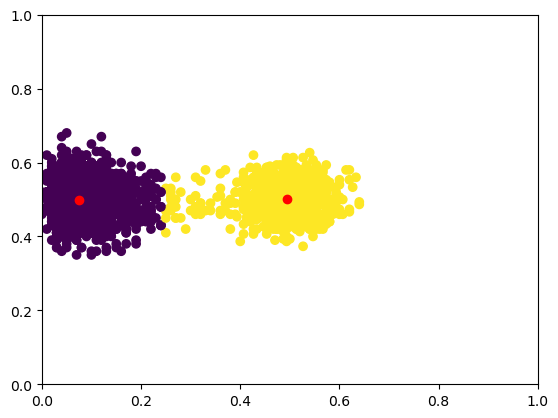

In [9]:
mb.fit(num_iter = 2000, lr = 0.001)

Using 3 components

In [10]:
N1 = 2000
N2 = 1000
N3 = 2000
NV1, DP1 = pareto_binomial_component(alpha=2, L=0.05, H=0.5, p=0.5, n=100, N=N1, seed = 123)
NV2, DP2 = beta_binomial_component(p_x=0.5, p_y=0.5, n=150, N=N2, seed=123)
NV3, DP3 = beta_binomial_component(p_x=0.3, p_y=0.3, n=150, N=N3, seed=123)
NV = torch.concat((NV1,NV2))
NV = torch.concat((NV,NV3))
print(NV.shape)
# print(NV)
DP = torch.concat((DP1,DP2))
DP = torch.concat((DP,DP3))
print(DP.shape)
# print(DP) 

torch.Size([5000, 2])
torch.Size([5000, 2])


In [11]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels_3 = np.ones(N3) * 3

labels = np.concatenate((labels_1, labels_2))
labels = np.concatenate((labels, labels_3))

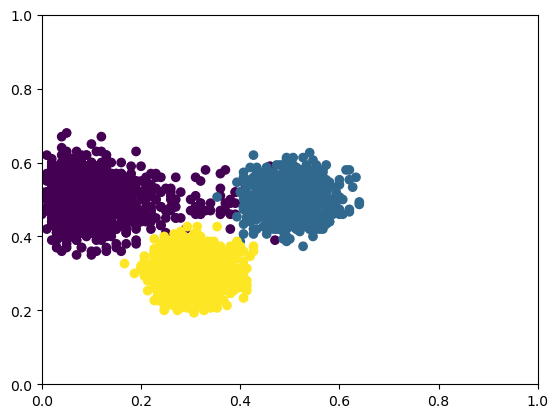

In [12]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

In [14]:
mb = mobster_MV(NV, DP, K = 3, seed = 12)

tensor([[0.0856, 0.4998],
        [0.3014, 0.3020],
        [0.4965, 0.5030]], grad_fn=<ClampBackward1>)
Iteration 0: Loss = 223764080.0
tensor([[0.0856, 0.4996],
        [0.3012, 0.3018],
        [0.4963, 0.5027]], grad_fn=<ClampBackward1>)
tensor([[0.0855, 0.4997],
        [0.3010, 0.3016],
        [0.4960, 0.5025]], grad_fn=<ClampBackward1>)
tensor([[0.0854, 0.4999],
        [0.3008, 0.3014],
        [0.4958, 0.5022]], grad_fn=<ClampBackward1>)
tensor([[0.0853, 0.5000],
        [0.3007, 0.3012],
        [0.4956, 0.5020]], grad_fn=<ClampBackward1>)
tensor([[0.0852, 0.5000],
        [0.3006, 0.3011],
        [0.4953, 0.5018]], grad_fn=<ClampBackward1>)
tensor([[0.0852, 0.4999],
        [0.3006, 0.3010],
        [0.4951, 0.5016]], grad_fn=<ClampBackward1>)
tensor([[0.0851, 0.4998],
        [0.3007, 0.3009],
        [0.4949, 0.5015]], grad_fn=<ClampBackward1>)
tensor([[0.0850, 0.4997],
        [0.3007, 0.3009],
        [0.4947, 0.5014]], grad_fn=<ClampBackward1>)
tensor([[0.0849, 0.4997

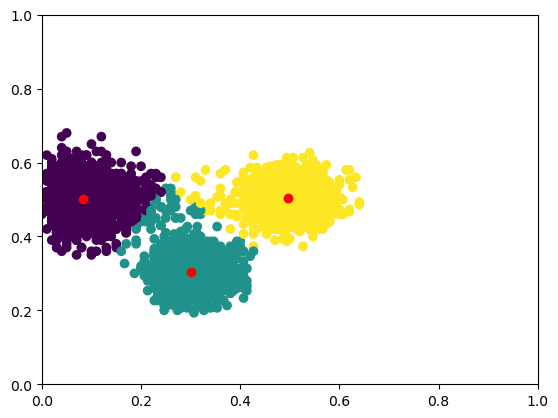

In [15]:
mb.fit(num_iter = 2000, lr = 0.001)

Using 4 components (1 beta private)

In [25]:
N1 = 2000
N2 = 1000
N3 = 2000
N4 = 1000
NV1, DP1 = pareto_binomial_component(alpha=2, L=0.05, H=0.5, p=0.5, n=100, N=N1, seed = 123)
NV2, DP2 = beta_binomial_component(p_x=0.5, p_y=0.5, n=150, N=N2, seed=123)
NV3, DP3 = beta_binomial_component(p_x=0.3, p_y=0.3, n=150, N=N3, seed=123)
NV4, DP4 = beta_binomial_component(p_x=0.3, p_y=0.0, n=150, N=N4, seed=123)
NV = torch.concat((NV1,NV2))
NV = torch.concat((NV,NV3))
NV = torch.concat((NV,NV4))
print(NV.shape)
# print(NV)
DP = torch.concat((DP1,DP2))
DP = torch.concat((DP,DP3))
DP = torch.concat((DP,DP4))
print(DP.shape)
# print(DP) 

torch.Size([6000, 2])
torch.Size([6000, 2])


In [26]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels_3 = np.ones(N3) * 3
labels_4 = np.ones(N4) * 4

labels = np.concatenate((labels_1, labels_2))
labels = np.concatenate((labels, labels_3))
labels = np.concatenate((labels, labels_4))

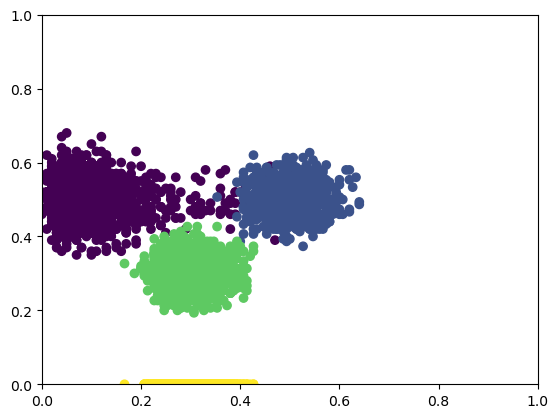

In [27]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

In [28]:
mb = mobster_MV(NV, DP, K = 4, seed = 12)

tensor([[8.5637e-02, 4.9982e-01],
        [3.0139e-01, 3.0203e-01],
        [4.9654e-01, 5.0297e-01],
        [3.0095e-01, 1.1755e-38]], grad_fn=<ClampBackward1>)
Iteration 0: Loss = -634056640.0
tensor([[8.5559e-02, 4.9957e-01],
        [3.0118e-01, 3.0182e-01],
        [4.9629e-01, 5.0272e-01],
        [3.0074e-01, 1.1755e-38]], grad_fn=<ClampBackward1>)
tensor([[8.5481e-02, 4.9937e-01],
        [3.0098e-01, 3.0161e-01],
        [4.9605e-01, 5.0247e-01],
        [3.0084e-01, 1.1755e-38]], grad_fn=<ClampBackward1>)
tensor([[8.5403e-02, 4.9929e-01],
        [3.0080e-01, 3.0140e-01],
        [4.9580e-01, 5.0223e-01],
        [3.0095e-01, 1.1755e-38]], grad_fn=<ClampBackward1>)
tensor([[8.5325e-02, 4.9932e-01],
        [3.0067e-01, 3.0119e-01],
        [4.9555e-01, 5.0199e-01],
        [3.0100e-01, 1.1755e-38]], grad_fn=<ClampBackward1>)
tensor([[8.5247e-02, 4.9939e-01],
        [3.0059e-01, 3.0099e-01],
        [4.9531e-01, 5.0177e-01],
        [3.0098e-01, 1.1755e-38]], grad_fn=<ClampB

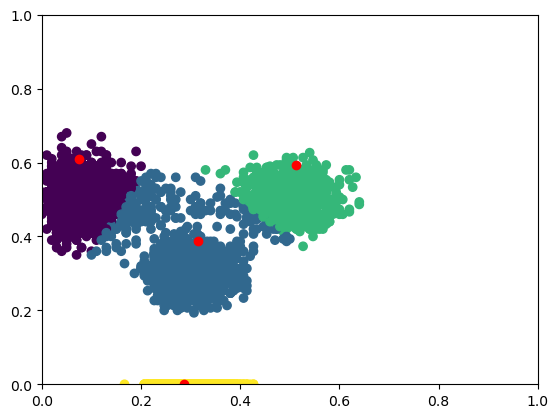

In [29]:
mb.fit(num_iter = 2000, lr = 0.001)